## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
numpy.random.seed(2012265)

In [2]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2020-11-17 15:59:26--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2020-11-17 15:59:26--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://uc9a0ad3e23f784a8221b88da912.dl.dropboxusercontent.com/cd/0/inline/BDUCxkdvzurgy90k_AvxE2mS-cJArkh9k835JAhyagy2iT41E8mKoIu2d06byJz1uUBwH21hTZbDsgV4SMfIWtPvAg5aK2AmElpbtPe9zM0rJNiQBTqCU9xkcAugj1jHEbE/file# [segue]
--2020-11-17 15:59:27--  https://uc9a0ad3e23f784a8221b88da912.dl.dropboxusercontent.com/cd/0/inline/BDUCxkdvzurgy90k_AvxE2mS-cJArkh9k835JAhyagy2iT41E8mKoIu2d06byJz1uUBwH21hTZbD

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

In [3]:
source_file = "./data/data_000637.txt"
lines = open(source_file)
N = min(len(list(lines)), 100000)
lines.close()

data = pandas.read_csv(source_file, header=0)#alternatively:#, nrows=N)

data.set_index(['FPGA', 'TDC_CHANNEL'], inplace=True)
data.sort_values(['TDC_MEAS','BX_COUNTER','ORBIT_CNT'], inplace=True)
data.sort_index(inplace=True)

data

HEAD   ORBIT_CNT  BX_COUNTER  TDC_MEAS
FPGA TDC_CHANNEL                                        
0    1               1  3869209693         179         0
     1               1  3869200678         227         0
     1               1  3869203991         239         0
     1               1  3869204538         259         0
     1               1  3869207842         278         0
...                ...         ...         ...       ...
1    139             1  3869203943        3563         0
     139             1  3869205490        3563         0
     139             1  3869208783        3563         0
     139             1  3869210274        3563         0
     139             1  3869210760        3563         0

[1310720 rows x 4 columns]

2\. Find out the number of BX in a ORBIT (the value 'x').

In [4]:
X = data['BX_COUNTER'].max() + 1
print(f"As far as we know, the number of BX_COUNTERS in one TDC_MEAS is at least: {X}")
print("The number could be higher than this, but we have no evidence of BX_COUNTER >= 3564")

As far as we know, the number of BX_COUNTERS in one TDC_MEAS is at least: 3564
The number could be higher than this, but we have no evidence of BX_COUNTER >= 3564


3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [5]:
time = data.loc[slice(None),'ORBIT_CNT':'TDC_MEAS']
time_max_TDC = time[time['TDC_MEAS'] == time['TDC_MEAS'].max()]
time_max_BX = time_max_TDC[time_max_TDC['BX_COUNTER'] == time_max_TDC['BX_COUNTER'].max()]
time_max_ORBIT = time_max_BX[time_max_BX['ORBIT_CNT'] == time_max_BX['ORBIT_CNT'].max()]
time_min_TDC = time[time['TDC_MEAS'] == time['TDC_MEAS'].min()]
time_min_BX = time_min_TDC[time_min_TDC['BX_COUNTER'] == time_min_TDC['BX_COUNTER'].min()]
time_min_ORBIT = time_min_BX[time_min_BX['ORBIT_CNT'] == time_min_BX['ORBIT_CNT'].min()]

time_weight = numpy.array([25/30, 25, 25*X])

print(f"We estimate that these data have been collected for {(numpy.dot(time_weight,numpy.array(time_max_ORBIT)[0].T) - numpy.dot(time_weight,numpy.array(time_min_ORBIT)[0].T)) / 1e06}ms")
print("We will check more precisely in the next answer, by reading the whole dataset")

We estimate that these data have been collected for 2.6817808333330153ms
We will check more precisely in the next answer, by reading the whole dataset


4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [6]:
data['TIME_NS'] = numpy.dot(time,time_weight)
print(f"We can now state that the data collecting took {(data['TIME_NS'].max() - data['TIME_NS'].min()) / 1e06}ms")

We can now state that the data collecting took 2.6819491666669846ms


5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [7]:
data['HEAD'] = numpy.random.binomial(1, 0.5, size=data.shape[0])
data

HEAD   ORBIT_CNT  BX_COUNTER  TDC_MEAS       TIME_NS
FPGA TDC_CHANNEL                                                      
0    1               1  3869209693         179         0  3.224346e+09
     1               1  3869200678         227         0  3.224340e+09
     1               0  3869203991         239         0  3.224343e+09
     1               0  3869204538         259         0  3.224344e+09
     1               0  3869207842         278         0  3.224347e+09
...                ...         ...         ...       ...           ...
1    139             0  3869203943        3563         0  3.224426e+09
     139             1  3869205490        3563         0  3.224427e+09
     139             1  3869208783        3563         0  3.224430e+09
     139             0  3869210274        3563         0  3.224431e+09
     139             0  3869210760        3563         0  3.224431e+09

[1310720 rows x 5 columns]

6\. Create a new DataFrame that contains only the rows with HEAD=1.

In [8]:
new_data = data[data['HEAD'] == 1]
new_data

HEAD   ORBIT_CNT  BX_COUNTER  TDC_MEAS       TIME_NS
FPGA TDC_CHANNEL                                                      
0    1               1  3869209693         179         0  3.224346e+09
     1               1  3869200678         227         0  3.224340e+09
     1               1  3869205318         397         0  3.224348e+09
     1               1  3869208486         416         0  3.224351e+09
     1               1  3869206612         549         0  3.224353e+09
...                ...         ...         ...       ...           ...
1    139             1  3869204765        3561         0  3.224426e+09
     139             1  3869204793        3561         0  3.224426e+09
     139             1  3869201773        3563         0  3.224424e+09
     139             1  3869205490        3563         0  3.224427e+09
     139             1  3869208783        3563         0  3.224430e+09

[655394 rows x 5 columns]

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

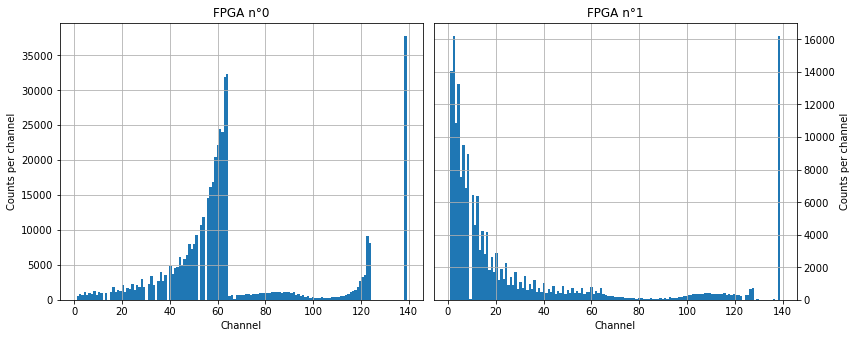

In [9]:
new_data.reset_index(level=1, inplace=True)

fig, axs = plt.subplots(1, 2, figsize=(12,4.8))

for i in [0,1]:
    new_data.loc[i, 'TDC_CHANNEL'].hist(ax=axs[i], bins=139)
    axs[i].set_ylabel("Counts per channel")
    axs[i].set_xlabel("Channel")
    axs[i].set_title("FPGA n°"+str(i))
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
fig.tight_layout()

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [10]:
print("The top noisy channels are:")
data.groupby(level=1).count().sort_values('HEAD', ascending=False).head()

The top noisy channels are:


,HEAD,ORBIT_CNT,BX_COUNTER,TDC_MEAS,TIME_NS
TDC_CHANNEL,,,,,
139,108059,108059,108059,108059,108059
64,66020,66020,66020,66020,66020
63,64642,64642,64642,64642,64642
61,49479,49479,49479,49479,49479
62,49349,49349,49349,49349,49349


9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [11]:
orbits = data['ORBIT_CNT'].unique()
print(f"The number of unique orbits is: {orbits.size}")
orbits139 = data.loc[(slice(None), 139), 'ORBIT_CNT'].unique()
print(f"If we want at least one measurement from TDC_CHANNEL 139, then the number is: {orbits139.size}")

The number of unique orbits is: 11001
If we want at least one measurement from TDC_CHANNEL 139, then the number is: 10976


In [12]:
!rm -r ./data